# Tutorial - Step2 : MTMR finetuning with Reinforcement learning

## 1. Import requirements

In [1]:
import os
import sys
import pandas as pd
import torch
import time
import matplotlib.pyplot as plt

In [2]:
sys.path = [os.path.abspath(os.path.join(os.getcwd(), os.pardir))] + sys.path

In [3]:
from MTMR.dataset import TrainingSmilesDataset, ValidationSmilesDataset
from MTMR.vae import SmilesAutoencoder, RewardFunction
from MTMR.properties import drd2, similarity

## 2. Configure GPU (if available)

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


## 3. Specify a target property

In [5]:
PROPERTY_NAME = "drd2"

SCORING_PROPERTY_FT = drd2
SCORING_TANIMOTO_FT = similarity

## Configure the parameters of a reward function for the target property
threshold_property = 0.
threshold_similarity = 0.3

## 4. Set directories (for inputs and outputs)

In [5]:
input_data_dir = os.path.abspath(os.path.join(os.pardir, "DATA", PROPERTY_NAME))
input_ckpt_dir = f"outputs_1-1_{PROPERTY_NAME.upper()}_pretraining"

In [6]:
output_dir = f"outputs_1-2_{PROPERTY_NAME.upper()}_finetuning"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

## 5. Set file names

In [7]:
filepath_train = os.path.join(input_data_dir, "rdkit_train_triplet.txt")
filepath_valid = os.path.join(input_data_dir, "rdkit_valid.txt")

In [8]:
filepath_pretrain_ckpt     = os.path.join(input_ckpt_dir, "checkpoints.pt")
filepath_pretrain_configs  = os.path.join(input_ckpt_dir, "configs.csv")
filepath_pretrain_char2idx = os.path.join(input_ckpt_dir, "char2idx.csv")

In [9]:
filepath_char2idx      = os.path.join(output_dir, "char2idx.csv")
filepath_configs       = os.path.join(output_dir, "configs.csv")
filepath_checkpoint    = os.path.join(output_dir, "checkpoints.pt")
filepath_history       = os.path.join(output_dir, "history.csv")
filepath_history_valid = os.path.join(output_dir, "history_valid.csv")

## 6. Load datasets (for training and validation)

In [10]:
dataset = TrainingSmilesDataset(filepath_train, filepath_char2idx=filepath_pretrain_char2idx, device=device)
dataset.save_char2idx(filepath_char2idx)
dataset_valid = ValidationSmilesDataset(filepath_valid, filepath_char2idx, device=device)

## 7. Load a pretrained generator of MTMR

In [11]:
## Model configuration
model_configs = {"hidden_size"    :None,
                 "latent_size"    :None,
                 "num_layers"     :None,
                 "vocab_size"     :None,
                 "sos_idx"        :None,
                 "eos_idx"        :None,
                 "pad_idx"        :None,
                 "device"         :device,
                 "filepath_config":filepath_pretrain_configs}

## Model initialization
generator = SmilesAutoencoder(**model_configs)

## Load pretrained model
generator.load_model(filepath_pretrain_ckpt)

## Configuration save
generator.save_config(filepath_configs)

## 8. Define a reward function

In [12]:
reward_ft = RewardFunction(similarity_ft=SCORING_TANIMOTO_FT,
                           scoring_ft=SCORING_PROPERTY_FT,
                           threshold_property=threshold_property,
                           threshold_similarity=threshold_similarity)

## 9. Train

In [13]:
df_history, df_history_valid = generator.policy_gradient(dataset, reward_ft,
                                                         validation_dataset=dataset_valid,
                                                         checkpoint_filepath=filepath_checkpoint)

df_history.to_csv(filepath_history, index=False)
df_history_valid.to_csv(filepath_history_valid, index=False)

[000000/002000]  loss: 0.014  reward: 0.224  similarity: 0.683  property: 0.085  valid_ratio(va): 0.998  similarity(va): 0.441  property(va): 0.046
[000010/002000]  loss: 0.012  reward: 0.212  similarity: 0.688  property: 0.055  valid_ratio(va): 1.000  similarity(va): 0.434  property(va): 0.073
[000020/002000]  loss: 0.016  reward: 0.208  similarity: 0.652  property: 0.067  valid_ratio(va): 1.000  similarity(va): 0.417  property(va): 0.109
[000030/002000]  loss: 0.014  reward: 0.210  similarity: 0.624  property: 0.100  valid_ratio(va): 1.000  similarity(va): 0.413  property(va): 0.125
[000040/002000]  loss: 0.019  reward: 0.270  similarity: 0.563  property: 0.163  valid_ratio(va): 1.000  similarity(va): 0.398  property(va): 0.170
[000050/002000]  loss: 0.021  reward: 0.336  similarity: 0.558  property: 0.245  valid_ratio(va): 1.000  similarity(va): 0.391  property(va): 0.181
[000060/002000]  loss: 0.019  reward: 0.344  similarity: 0.548  property: 0.247  valid_ratio(va): 1.000  similar

[000560/002000]  loss: 0.032  reward: 0.714  similarity: 0.447  property: 0.681  valid_ratio(va): 1.000  similarity(va): 0.324  property(va): 0.667
[000570/002000]  loss: 0.034  reward: 0.699  similarity: 0.459  property: 0.663  valid_ratio(va): 1.000  similarity(va): 0.319  property(va): 0.656
[000580/002000]  loss: 0.031  reward: 0.779  similarity: 0.422  property: 0.749  valid_ratio(va): 1.000  similarity(va): 0.329  property(va): 0.668
[000590/002000]  loss: 0.030  reward: 0.750  similarity: 0.439  property: 0.734  valid_ratio(va): 1.000  similarity(va): 0.332  property(va): 0.660
[000600/002000]  loss: 0.028  reward: 0.740  similarity: 0.453  property: 0.716  valid_ratio(va): 0.998  similarity(va): 0.324  property(va): 0.681
[000610/002000]  loss: 0.032  reward: 0.775  similarity: 0.447  property: 0.756  valid_ratio(va): 1.000  similarity(va): 0.326  property(va): 0.676
[000620/002000]  loss: 0.032  reward: 0.717  similarity: 0.457  property: 0.673  valid_ratio(va): 1.000  similar

[001120/002000]  loss: 0.030  reward: 0.778  similarity: 0.456  property: 0.750  valid_ratio(va): 1.000  similarity(va): 0.333  property(va): 0.745
[001130/002000]  loss: 0.028  reward: 0.875  similarity: 0.424  property: 0.843  valid_ratio(va): 1.000  similarity(va): 0.330  property(va): 0.757
[001140/002000]  loss: 0.031  reward: 0.834  similarity: 0.444  property: 0.814  valid_ratio(va): 1.000  similarity(va): 0.325  property(va): 0.738
[001150/002000]  loss: 0.031  reward: 0.828  similarity: 0.430  property: 0.790  valid_ratio(va): 1.000  similarity(va): 0.325  property(va): 0.761
[001160/002000]  loss: 0.030  reward: 0.794  similarity: 0.448  property: 0.764  valid_ratio(va): 1.000  similarity(va): 0.327  property(va): 0.757
[001170/002000]  loss: 0.031  reward: 0.820  similarity: 0.456  property: 0.800  valid_ratio(va): 1.000  similarity(va): 0.320  property(va): 0.761
[001180/002000]  loss: 0.026  reward: 0.840  similarity: 0.429  property: 0.812  valid_ratio(va): 1.000  similar

[001680/002000]  loss: 0.032  reward: 0.860  similarity: 0.438  property: 0.814  valid_ratio(va): 1.000  similarity(va): 0.334  property(va): 0.781
[001690/002000]  loss: 0.029  reward: 0.873  similarity: 0.436  property: 0.854  valid_ratio(va): 1.000  similarity(va): 0.335  property(va): 0.770
[001700/002000]  loss: 0.031  reward: 0.838  similarity: 0.436  property: 0.812  valid_ratio(va): 1.000  similarity(va): 0.328  property(va): 0.775
[001710/002000]  loss: 0.026  reward: 0.845  similarity: 0.467  property: 0.833  valid_ratio(va): 1.000  similarity(va): 0.329  property(va): 0.787
[001720/002000]  loss: 0.031  reward: 0.888  similarity: 0.431  property: 0.873  valid_ratio(va): 1.000  similarity(va): 0.327  property(va): 0.772
[001730/002000]  loss: 0.030  reward: 0.836  similarity: 0.436  property: 0.820  valid_ratio(va): 1.000  similarity(va): 0.330  property(va): 0.794
[001740/002000]  loss: 0.029  reward: 0.855  similarity: 0.427  property: 0.826  valid_ratio(va): 1.000  similar

## 10. Visualize for reward & loss analysis

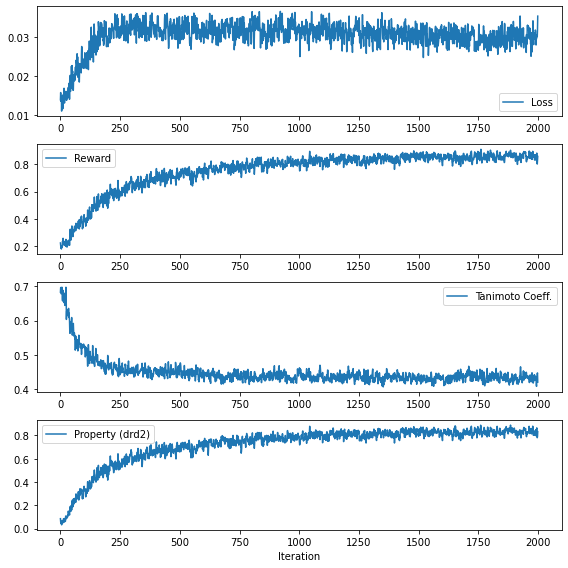

In [14]:
fig, axes = plt.subplots(4,1,figsize=(8,8))

axes[0].plot(df_history.loc[:,"LOSS"], label="Loss")
axes[1].plot(df_history.loc[:,"REWARD"], label="Reward")
axes[2].plot(df_history.loc[:,"SIMILARITY"], label="Tanimoto Coeff.")
axes[3].plot(df_history.loc[:,"PROPERTY"], label=f"Property ({PROPERTY_NAME})")

axes[3].set_xlabel("Iteration")
for ax in axes:
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

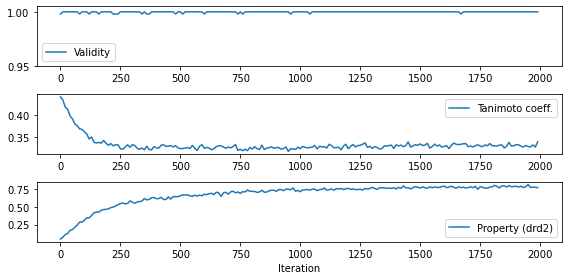

In [16]:
fig, axes = plt.subplots(3,1,figsize=(8,4))

axes[0].plot(df_history_valid.loc[:,"VALID_RATIO"], label="Validity")
axes[1].plot(df_history_valid.loc[:,"AVERAGE_SIMILARITY"], label="Tanimoto coeff.")
axes[2].plot(df_history_valid.loc[:,"AVERAGE_PROPERTY"], label=f"Property ({PROPERTY_NAME})")

axes[0].set_ylim(0.95, 1.005)

axes[2].set_xlabel("Iteration")
for ax in axes:
    ax.legend(loc='best')

plt.tight_layout()
plt.show()